## Helpers

In [189]:
import pandas as pd
import os
from glob import glob

def load_and_merge_csvs(folder_path, method_name):
    """
    Load and merge all CSV files in a given folder.
    
    Parameters:
        folder_path (str): Path to the folder containing the CSV files.
        method_name (str): Name of the method to tag (e.g. "CoT").
    
    Returns:
        pd.DataFrame: Merged DataFrame with method and run columns.
    """
    # Find all CSV files in the folder
    csv_files = sorted(glob(os.path.join(folder_path, "*.csv")))

    dataframes = []
    for i, file_path in enumerate(csv_files):
        df = pd.read_csv(file_path)
        df["method"] = method_name
        df["run"] = i + 1
        dataframes.append(df)

    # Merge all into one DataFrame
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

## Load cleaned data

### CoT

In [190]:
cot_all = load_and_merge_csvs("results/cot_few-shot_clean", method_name="CoT")
cot_all.tail()

,id,subject,ground_truth,predicted,correct,method,run
3595,questao_176,Mathematics,D,D,True,CoT,20
3596,questao_177,Mathematics,A,B,False,CoT,20
3597,questao_178,Mathematics,D,D,True,CoT,20
3598,questao_179,Mathematics,C,E,False,CoT,20
3599,questao_180,Mathematics,B,A,False,CoT,20


### CoVe

In [191]:
cove_all = load_and_merge_csvs("results/cove_few-shot_clean", method_name="CoVe")
cove_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
2875,questao_176,Mathematics,D,D,True,D,CoVe,16
2876,questao_177,Mathematics,A,B,False,A,CoVe,16
2877,questao_178,Mathematics,D,D,True,D,CoVe,16
2878,questao_179,Mathematics,C,B,False,B,CoVe,16
2879,questao_180,Mathematics,B,A,False,A,CoVe,16


### Self-Refine

In [192]:
selfrefine_all = load_and_merge_csvs("results/self-refine_few-shot_clean", method_name="Self-Refine")
selfrefine_all.tail()

,id,subject,ground_truth,predicted,correct,initial_answer,method,run
2875,questao_176,Mathematics,D,D,True,D,Self-Refine,16
2876,questao_177,Mathematics,A,D,False,C,Self-Refine,16
2877,questao_178,Mathematics,D,A,False,D,Self-Refine,16
2878,questao_179,Mathematics,C,C,True,E,Self-Refine,16
2879,questao_180,Mathematics,B,A,False,A,Self-Refine,16


### Dataset Summary

In [193]:
print(f"{'Method':<15}{'Rows':<10}{'Columns':<10}{'Runs':<10}{'Unique IDs':<15}")
print("-" * 60)
print(f"{'CoT':<15}{cot_all.shape[0]:<10}{cot_all.shape[1]:<10}{cot_all['run'].nunique():<10}{cot_all['id'].nunique():<15}")
print(f"{'CoVe':<15}{cove_all.shape[0]:<10}{cove_all.shape[1]:<10}{cove_all['run'].nunique():<10}{cove_all['id'].nunique():<15}")
print(f"{'Self-Refine':<15}{selfrefine_all.shape[0]:<10}{selfrefine_all.shape[1]:<10}{selfrefine_all['run'].nunique():<10}{selfrefine_all['id'].nunique():<15}")


Method         Rows      Columns   Runs      Unique IDs     
------------------------------------------------------------
CoT            3600      7         20        180            
CoVe           2880      8         16        180            
Self-Refine    2880      8         16        180            


## Accuracy per Run: Mean

#### Concat data from each method

In [194]:
accuracy_by_run = pd.concat([cot_all, cove_all, selfrefine_all], ignore_index=True)

#### Calculate mean accuracy per method and test run

In [195]:
run_stats = accuracy_by_run.groupby(["method", "run"])["correct"].mean().reset_index()

print("Per-run Accuracy:")
print(run_stats.pivot(index="run", columns="method", values="correct").round(3))

Per-run Accuracy:
method    CoT   CoVe  Self-Refine
run                              
1       0.672  0.672        0.700
2       0.722  0.683        0.694
3       0.661  0.650        0.678
4       0.706  0.672        0.706
5       0.711  0.728        0.722
6       0.711  0.650        0.683
7       0.694  0.639        0.700
8       0.700  0.667        0.700
9       0.706  0.644        0.683
10      0.706  0.650        0.700
11      0.722  0.689        0.683
12      0.683  0.683        0.700
13      0.694  0.683        0.667
14      0.717  0.661        0.656
15      0.711  0.689        0.672
16      0.678  0.672        0.694
17      0.717    NaN          NaN
18      0.667    NaN          NaN
19      0.700    NaN          NaN
20      0.711    NaN          NaN


## General Accuracy: General Mean and Standard Deviation

In [196]:
# Compute the number of unique runs per method from the original data.
runs_count = accuracy_by_run.groupby("method")["run"].nunique().reset_index(name="runs")
print("Runs count per method:")
print(runs_count)

# Group by method, subject, and run to compute the per-run average correctness.
df_grouped = accuracy_by_run.groupby(["method", "subject", "run"])["correct"].mean().reset_index()

# Aggregate across runs (across all subjects) for each method.
df_overall = df_grouped.groupby("method")["correct"].agg(["mean", "std"]).reset_index()
df_overall.rename(columns={"mean": "accuracy_mean_all", "std": "accuracy_std_all"}, inplace=True)

# Merge the runs count into df_overall.
df_overall = df_overall.merge(runs_count, on="method")

print("\nOverall Accuracy with Number of Runs:")
print(df_overall)


Runs count per method:
        method  runs
0          CoT    20
1         CoVe    16
2  Self-Refine    16

Overall Accuracy with Number of Runs:
        method  accuracy_mean_all  accuracy_std_all  runs
0          CoT           0.699444          0.193631    20
1         CoVe           0.670833          0.208834    16
2  Self-Refine           0.689931          0.191139    16


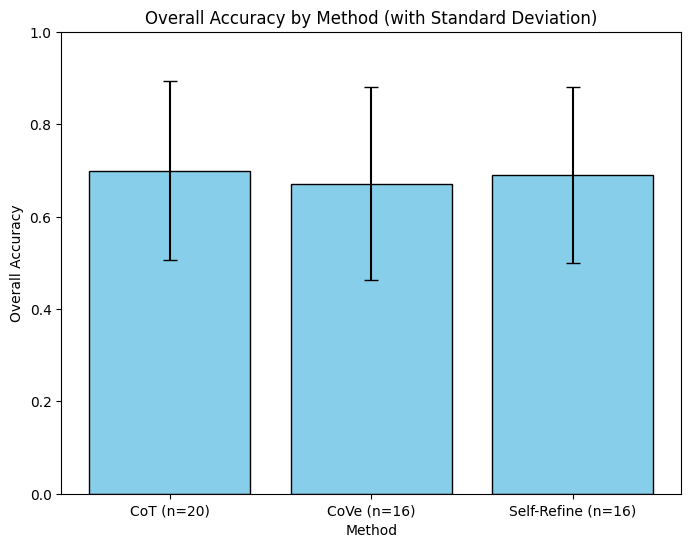

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
bars = plt.bar(
    df_overall["method"],
    df_overall["accuracy_mean_all"],
    yerr=df_overall["accuracy_std_all"],
    capsize=5,
    color="skyblue",
    edgecolor="black"
)
plt.xlabel("Method")
plt.ylabel("Overall Accuracy")
plt.title("Overall Accuracy by Method (with Standard Deviation)")
plt.ylim(0, 1)  # Adjust if your accuracy scale is 0-1

# Create new x-axis labels that include the run count
new_labels = [f"{m} (n={r})" for m, r in zip(df_overall["method"], df_overall["runs"])]

# Replace the default tick labels with the new labels
plt.xticks(ticks=range(len(new_labels)), labels=new_labels)

plt.show()


## Accuracy per Subject: Mean and Standard Deviation

### Aggregate per Subject

In [198]:
df_agg = (
    accuracy_by_run.groupby(["method", "subject", "run"])["correct"]
    .mean()  # Average correctness per run
    .groupby(["method", "subject"])
    .agg(accuracy_mean="mean", accuracy_std="std")  # Aggregate across runs
    .reset_index()
)

### Mean

In [199]:
df_accuracy_mean_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_mean")

df_accuracy_mean_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.955556,0.800000,0.480000,0.562222
CoVe,0.937500,0.786111,0.411111,0.548611
Self-Refine,0.950000,0.780556,0.491667,0.537500


### Standard Deviation

In [200]:
df_accuracy_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_std")

df_accuracy_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.024976,0.025995,0.052686,0.040207
CoVe,0.028364,0.037074,0.038915,0.039519
Self-Refine,0.022222,0.045812,0.037074,0.043105


### Mean and Standard Deviation

In [201]:
df_agg["accuracy_formatted"] = df_agg.apply(
    lambda row: f"{row['accuracy_mean']:.3f} ± {row['accuracy_std']:.3f}", axis=1
)

df_accuracy_mean_std_per_subject = df_agg.pivot(index="method", columns="subject", values="accuracy_formatted")

df_accuracy_mean_std_per_subject

subject,Human Sciences,Languages,Mathematics,Natural Sciences
method,,,,
CoT,0.956 ± 0.025,0.800 ± 0.026,0.480 ± 0.053,0.562 ± 0.040
CoVe,0.938 ± 0.028,0.786 ± 0.037,0.411 ± 0.039,0.549 ± 0.040
Self-Refine,0.950 ± 0.022,0.781 ± 0.046,0.492 ± 0.037,0.537 ± 0.043


### 📊 Accuracy per Subject: Mean and Std

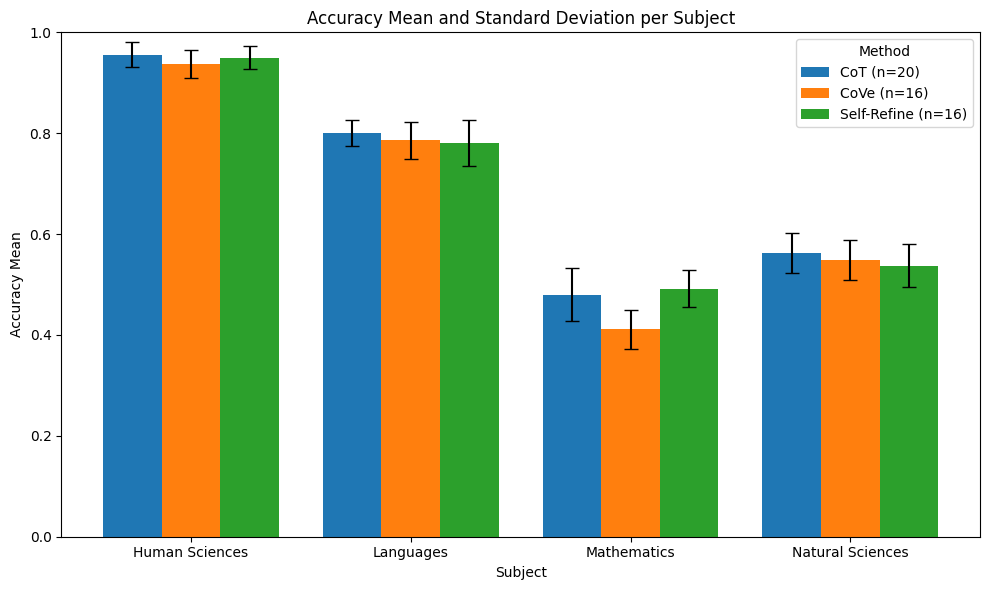

In [202]:
import matplotlib.pyplot as plt
import numpy as np

# Compute the overall number of runs per method from your original dataset.
runs_count_overall = accuracy_by_run.groupby("method")["run"].nunique()
runs_dict = runs_count_overall.to_dict()

# Extract subjects (columns) and methods (rows) from your pivot tables.
subjects = df_accuracy_mean_per_subject.columns.tolist()
methods = df_accuracy_mean_per_subject.index.tolist()

# Create positions on the x-axis for each subject.
n_subjects = len(subjects)
x = np.arange(n_subjects)

# Set the bar width based on the number of methods.
bar_width = 0.8 / len(methods)  # use 80% of the space per group

plt.figure(figsize=(10, 6))

# Plot bars for each method with error bars.
for i, method in enumerate(methods):
    # Retrieve mean and std values for the current method.
    means = df_accuracy_mean_per_subject.loc[method].values
    stds = df_accuracy_std_per_subject.loc[method].values

    # Calculate the offset for this method's bars.
    offset = (i - (len(methods) - 1) / 2) * bar_width

    # Label including the run count, e.g., "CoT (n=728)"
    label_with_runs = f"{method} (n={runs_dict.get(method, '?')})"
    
    plt.bar(x + offset, means, bar_width, yerr=stds, capsize=5, label=label_with_runs)

# Set x-axis labels and other plot details.
plt.xticks(x, subjects)
plt.xlabel("Subject")
plt.ylabel("Accuracy Mean")
plt.title("Accuracy Mean and Standard Deviation per Subject")
plt.ylim(0, 1)  # adjust if your accuracy is on a different scale
plt.legend(title="Method")
plt.tight_layout()
plt.show()
